In [1]:
import pandas as pd
import regex as re
import unicodedata
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
with open('stops.txt') as f:
    lines = f.readlines()
stops = [i.strip() for i in lines]
stops = stops + ['canadian','european','chinese','norwegian','british','german']

### Base Case

In [3]:
data = pd.read_csv('clean_data.csv')
data['cleaned_text'] = data['cleaned_text'].astype(str)
data = data.loc[:,['cleaned_text','peace']]
data = data.dropna()
X = data['cleaned_text']
Y = data['peace']
dev_x, test_x, dev_y, test_y = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [4]:
vectorizer = CountVectorizer(stop_words = stops,max_features=3000, min_df=10, max_df = 0.5)
dev_x = vectorizer.fit_transform(dev_x)
test_x = vectorizer.transform(test_x)
model = LogisticRegression().fit(dev_x,dev_y)

/Users/eyyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
print(confusion_matrix(test_y, model.predict(test_x)))
print(model.score(test_x,test_y))

[[49944 12081]
 [ 9106 52582]]
0.8287407143954152


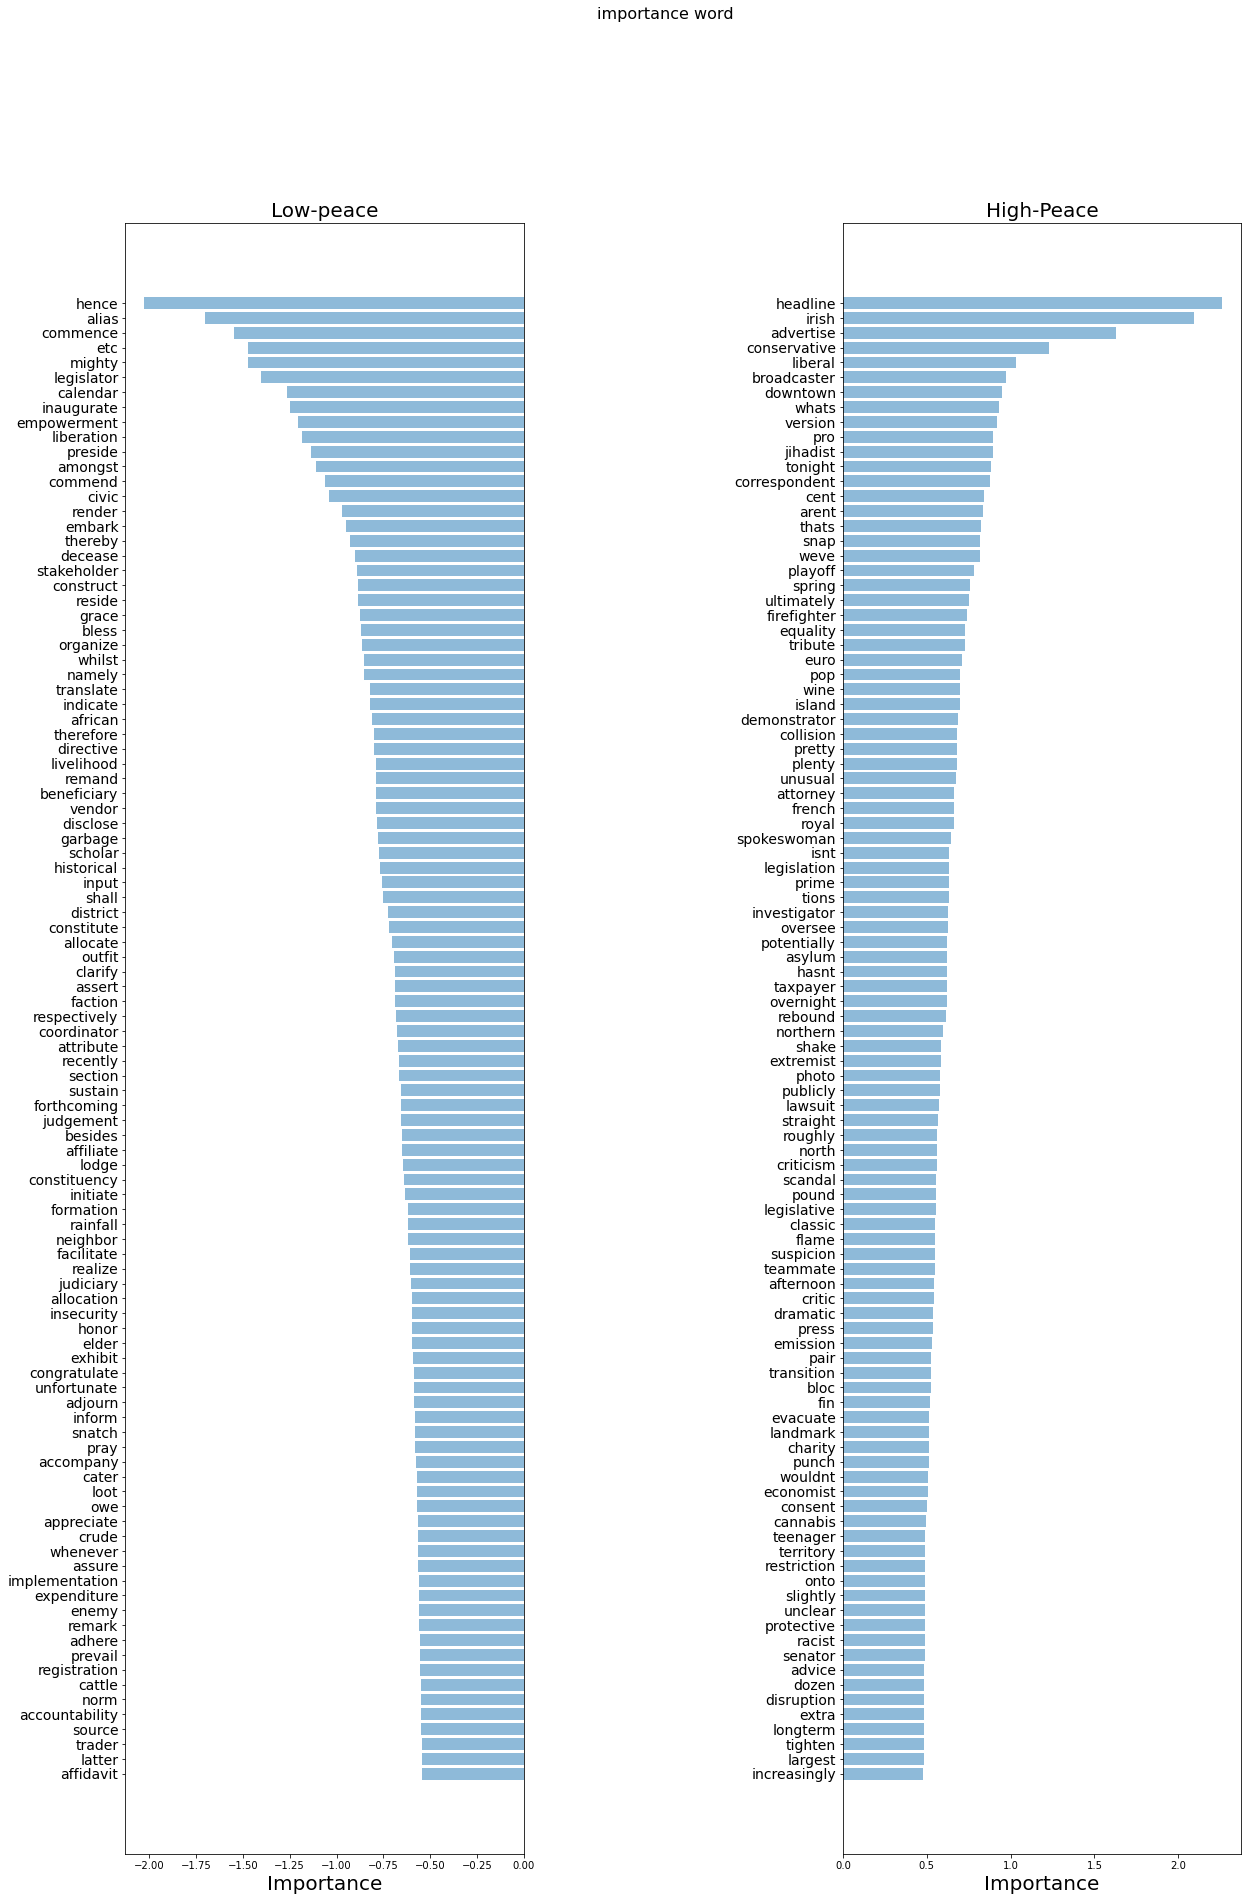

In [6]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])] #去拿系数
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True) 
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vectorizer, model, 100)

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(20, 30))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Low-peace', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('High-Peace', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words,'importance word')


In [7]:
with open('words_log_peace.txt', 'w') as f:
    for word in top_words:
        f.write(word)
        f.write('\n')
with open('words_log_lowpeace.txt', 'w') as f:
    for word in bottom_words:
        f.write(word)
        f.write('\n')

## Model with only nouns

In [8]:
def noun_text(text):
    tokenized = nltk.word_tokenize(text)
    text = ' '.join([word for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')])

    return text

In [9]:
data['noun'] = data['cleaned_text'].map(noun_text)

In [10]:
X = data['noun']
Y = data['peace']
dev_x, test_x, dev_y, test_y = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [11]:
vectorizer = CountVectorizer(stop_words = stops,max_features=3000, min_df=10, max_df = 0.5)
dev_x = vectorizer.fit_transform(dev_x)
test_x = vectorizer.transform(test_x)
model = LogisticRegression().fit(dev_x,dev_y)

importance = get_most_important_features(vectorizer, model, 100)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

with open('words_log_noun_peace.txt', 'w') as f:
    for word in top_words:
        f.write(word)
        f.write('\n')
with open('words_log_noun_lowpeace.txt', 'w') as f:
    for word in bottom_words:
        f.write(word)
        f.write('\n')

/Users/eyyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_y, model.predict(test_x)))
print(model.score(test_x,test_y))

[[48183 13842]
 [10578 51110]]
0.8026076483473846


## Model with shuffle text

In [13]:
def shuffle_text(text):
    tokenized = nltk.word_tokenize(text)
    random.shuffle(tokenized)
    text = ' '.join(tokenized)

    return text

In [14]:
data['shuffle'] = data['cleaned_text'].map(shuffle_text)

In [15]:
X = data['shuffle']
Y = data['peace']
dev_x, test_x, dev_y, test_y = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [16]:
vectorizer = CountVectorizer(stop_words = stops,max_features=3000, min_df=10, max_df = 0.5)
dev_x = vectorizer.fit_transform(dev_x)
test_x = vectorizer.transform(test_x)
model = LogisticRegression().fit(dev_x,dev_y)

importance = get_most_important_features(vectorizer, model, 100)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

with open('words_log_shuffle_peace.txt', 'w') as f:
    for word in top_words:
        f.write(word)
        f.write('\n')
with open('words_log_shuffle_lowpeace.txt', 'w') as f:
    for word in bottom_words:
        f.write(word)
        f.write('\n')

/Users/eyyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_y, model.predict(test_x)))
print(model.score(test_x,test_y))

[[49944 12081]
 [ 9106 52582]]
0.8287407143954152
